# NeuroEvolution of Augmenting Topologies (NEAT)

In this notebook, we will study the use of NEAT-python framework. 

- Installation guidelines: <a href='https://neat-python.readthedocs.io/en/latest/installation.html'>here.</a>

- Framework documentation: <a href='https://neat-python.readthedocs.io/en/latest/neat_overview.html'>here.</a>

<br />

## 1. Environment preparation

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

import torch
import neat
#import visualize # local file


import sys
import os
parent_dir = os.path.abspath(os.path.join(os.path.dirname('../NEUROEVOLUTION'), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
    
from NEUROEVOLUTION.utils import drop_features


### Global settings

In [2]:
seed = 1
device = 'cpu'
target = 'lactose'
train_size = 150

## 2. XOR data simulation


As we did for backpropagation Neural Networks, let's run our examples for a very simple non-linear binary classification problem.


In [3]:



X = pd.read_csv('../datamart/data_project_nel.csv')
X = torch.tensor(drop_features(X).values)
y = torch.tensor(pd.read_csv('../datamart/y_' + f'{target}'+ '.csv')['lactose_percent'].values)

X=X.numpy()
y=y.numpy()

X_train = X[:train_size, :]
y_train = y[:train_size]
X_val = X[train_size:, :]
y_val = y[train_size:]

print([X_train.shape, y_train.shape])
print([X_val.shape, y_val.shape])


[(150, 12), (150,)]
[(174, 12), (174,)]


## 3. NEAT Configuration File and Object

In NEAT-python, there are four main steps for defining the algorithm settings. They are hadled with NEAT-python classes:

1. **Genome**: NN genome (structure, representation). This class has the methods for initializing, and applying mutation and corssover to  candidate solutions;
2. **Reproduction**: it encapsulates the reproduction (selection and genetic operators) scheme of NEAT;
3. **Species**: it encapsulates the default speciation scheme of NEAT; and
4. **Stagnation**: it keeps track of whether species are making progress and helps removing ones that are not.

NEAT-python provides default classes for each of these configuration modules. In this notebook, we'll be using these default classes provided by the framework NEAT-python. Notice however, that the user can create its own genome, reproduction, species and stagnation classes, extending and modifying the algorithm according to its goals.


The specific definitions for each of these components of the algorithm will be set in a text file. In this file, the main sections are marked with square brakets (`[]`), and the settings are parameters that receive the appropiate values.

1. **Genome**: `[DefaultGenome]` section;
2. **Reproduction**: `[DefaultReproduction]` section;
3. **Species**: `[DefaultSpeciesSet]` section; and
4. **Stagnation**: `[DefaultStagnation]` section.

Let's study the configuration file:

For available configuration options, check the 
<a href='https://github.com/CodeReclaimers/neat-python/blob/master/neat'>NEAT-python github repository</a>.

In [4]:
config_file = 'config-feedforward-xor'
# with open(config_file, 'r') as f:
#     print(f.read())
    

In [5]:
# file_content = None
# with open(config_file, 'r', encoding='utf-8') as f:
#         file_content = f.read()

<br />

The settings defined in this configuration file are used, together with the classes for each of these configuration modelus, to create the `config` object:


In [6]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, filename=config_file)


In [7]:
import neat
import configparser

def read_config_file(config_file):
    config = configparser.ConfigParser()
    
    # Try with 'utf-8' encoding first
    try:
        with open(config_file, 'r', encoding='utf-8') as f:
            config.read_file(f)
    except UnicodeDecodeError:
        # If 'utf-8' fails, try 'latin-1' encoding
        with open(config_file, 'r', encoding='latin-1') as f:
            config.read_file(f)
    
    return config

config_file = 'config-feedforward-xor'
config = read_config_file(config_file)

# Now pass the file name to the neat.Config constructor
neat_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                          neat.DefaultSpeciesSet, neat.DefaultStagnation,
                          config_file)


## 4. Fitness function

The fitness function is not specified in the configuration file. In NEAT-python, the fitness function is always user-defined, and it is given as an argument of the learning loop method.

As we have a binary classification with a balanced dataset for training, let's use the **Accuracy** of the classifier as fitness function. **In NEAT-python the fitness is always maximized**.

Besides the fitness used for algorithm evolution, at this method, other metrics can be evaluated. In the example below, the RMSE is also being evaluated. You can create any metric you need.

<br />


In [8]:
def eval_rmse(net, X, y):
    '''
    Auxiliary funciton to evaluate the RMSE.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = net.activate(xi)
        fit += (output[0] - xo)**2
    # RMSE
    return (fit/y.shape[0])**.5

def eval_accuracy(net, X, y):
    '''
    Auxiliary funciton to evaluate the accuracy.
    '''
    fit = 0.
    for xi, xo in zip(X, y):
        output = 1. if net.activate(xi)[0] >= .5 else 0.
        fit += output==xo
    # ACCURACY
    return fit/y.shape[0]

def eval_genomes(genomes, config):
    '''
    The function used by NEAT-Python to evaluate the fitness of the genomes.
    -> It has to have the two first arguments equals to the genomes and config objects.
    -> It has to update the `fitness` attribute of the genome.
    '''
    for genome_id, genome in genomes:
        # Define the network
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Train fitness
        genome.rmse = eval_rmse(net, X_train, y_train)
        genome.fitness = eval_accuracy(net, X_train, y_train)
        # Validation fitness
        genome.rmse_val = eval_rmse(net, X_val, y_val)
        genome.fitness_val = eval_accuracy(net, X_val, y_val)
        

## 5. Population creation

The first step on creating a NEAT run is instantiating a population.

In [9]:
# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(neat_config)


## 6. Run

In [10]:
# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))


In [11]:
# Run until threshold defined in the confgiuration file or up to max generations.
winner = p.run(eval_genomes, 100)



 ****** Running generation 0 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 1.732, standard deviation 1.262
Population of 100 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    95      0.0    0.000     0
     2    0     5       --       --     0
Total extinctions: 0
Generation time: 0.093 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 2.740, standard deviation 1.420
Population of 100 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    80      0.0    0.000     1
     2    1     6      0.0    0.000     0
     3    0     9       --       --     0
     4    0     5       --

In [16]:
eval_rmse(winner, X_val, y_val)

AttributeError: 'DefaultGenome' object has no attribute 'activate'

<br />

The NN solution returned by NEAT:

In [12]:
print(str(winner))

Key: 1
Fitness: 0.0
Nodes:
	0 DefaultNodeGene(key=0, bias=0.09268804529724393, response=1.0, activation=sigmoid, aggregation=sum)
Connections:


In [13]:
# node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
# visualize.draw_net(config, winner, True, node_names=node_names, prune_unused=True)
visualize.draw_net(config, winner, True, prune_unused=True)


NameError: name 'visualize' is not defined

In [ ]:
# Show output of the most fit genome against training data.
print('\nOutput:')

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

for xi, xo in zip(X_train[:3, :], y_train[:3]):
    output = winner_net.activate(xi)
    print("  expected output {!r}, got {!r}".format(xo, output))



Output:
  expected output 1.0, got [0.5471262712548488]
  expected output 0.0, got [2.1436451727096557]
  expected output 0.0, got [2.911139573344554]


## 7. Algorithm evolution

Accuracy: [0.7533333333333333, 0.74]


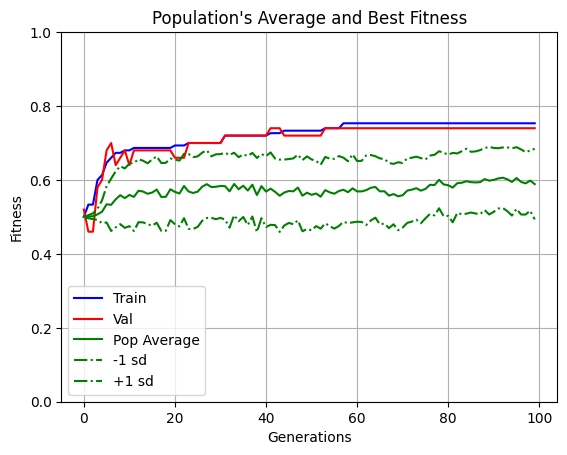

In [ ]:
print('Accuracy: {}'.format([winner.fitness, winner.fitness_val]))

visualize.plot_stats(stats, ylog=False, show_pop=True, invert_y=False, y_max=1., view=True)


RMSE: [1.5594766508774973, 1.6441575052968023]


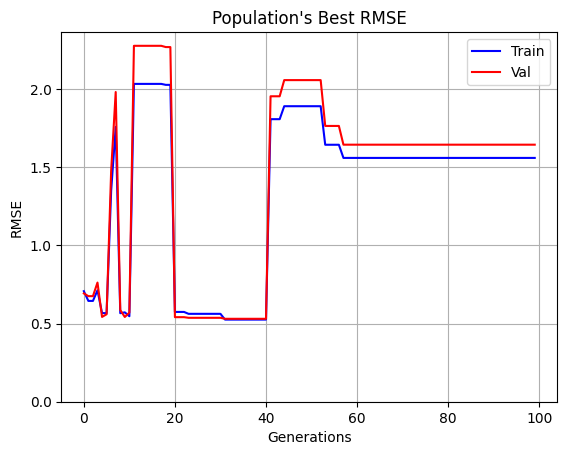

In [ ]:
print('RMSE: {}'.format([winner.rmse, winner.rmse_val]))
visualize.plot_stats_metrics(stats, metric='rmse', metric_name='RMSE', ylog=False, view=True)


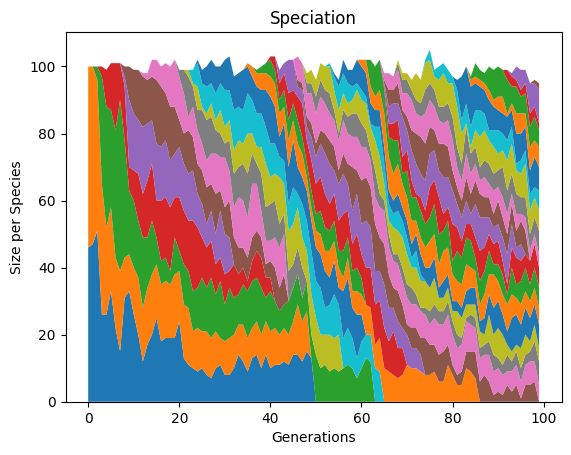

In [ ]:
visualize.plot_species(stats, view=True)

<br />

<hr />

<br />

##### **Exercise 1**
**Play with NEAT-python settings to improve the algorithm performance.**

<br />

<br />

##### **Exercise 2**
**Modify the fitness function to the RMSE.**

<br />

##### **Exercise 3**
**Run NEAT-python for Boston dataset (it is available in the folder `datamart`).**
> *Hint: create a new configuration file specific for modelling Boston dataset.*

<br />

<hr />

<br />
<br />